In [44]:
import pandas as pd 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#export
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp
import time 

In [134]:

jnp.zeros((10,))

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [3]:
key = random.PRNGKey(0)

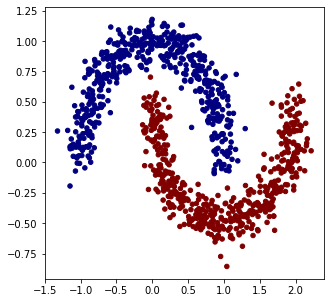

In [373]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=1000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [374]:
random.uniform(random.PRNGKey(0), (10, 10),minval=-1,maxval=1).std()

DeviceArray(0.55754423, dtype=float32)

In [375]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  # return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
  return scale * random.uniform(w_key,(n,m),minval=-1,maxval=1), jnp.zeros((n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key,scale):
  keys = random.split(key, len(sizes))
  W = []
  b = []
  for m, n, k in zip(sizes[:-1], sizes[1:], keys):
    _w, _b = random_layer_params(m, n, k,scale)
    W.append(_w)
    b.append(_b)
  return W,b

layer_sizes = [2, 16,16, 1]
param_scale = 0.1
step_size = 0.1
num_epochs = 10
batch_size = 128
n_targets = 1
W,B = init_network_params(layer_sizes, random.PRNGKey(0),1)

In [376]:
def relu(x): return jnp.maximum(0,x)

In [377]:
def predict(W,B,x):
  act = x
  for w,b in list(zip(W,B))[:-1]:
    act = relu(jnp.dot(w,act) + b)
  
  act = jnp.dot(W[-1],act) + B[-1]
  return act

In [378]:

preds = predict(W,B, X[0])
print(preds)

[-0.0409683]


In [379]:
batched_predict = vmap(predict, in_axes=(None,None,0))

batched_preds = batched_predict(W,B, X[:10])
pd.DataFrame({'x1':X[:10,0],'x2':X[:10,1],'target':y[:10],'score':batched_preds})


,x1,x2,target,score
0,0.057160,0.571047,1,"(-0.0409683,)"
1,1.703601,-0.237167,1,"(-1.0387001,)"
2,1.684032,-0.190388,1,"(-0.94112664,)"
3,0.182042,0.964522,-1,"(-0.045408845,)"
4,0.572257,0.799623,-1,"(-0.020296335,)"
5,0.884094,0.746917,-1,"(-0.0039577964,)"
6,0.604952,0.587421,-1,"(-0.0037251418,)"
7,0.165585,0.843789,-1,"(-0.037963927,)"
8,0.749369,-0.298538,1,"(-0.98041224,)"
9,1.082878,-0.364842,1,"(-1.2378355,)"


In [380]:
jnp.arange(10)

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [381]:
loss(W,B, X[:1],y[:1]),X[:1],y[:1],predict(W,B,X[0])

(DeviceArray(1.0507041, dtype=float32),
 array([[0.0571601 , 0.57104655]]),
 array([1]),
 DeviceArray([-0.0409683], dtype=float32))

In [382]:
preds = batched_predict(W,B, X[:10])

In [383]:
accuracy(W,B,X,y)

DeviceArray(0.5, dtype=float32)

In [384]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
# def accuracy(W,b, inputs, targets):
#   target_class = jnp.argmax(targets, axis=1)
#   predicted_class = jnp.argmax(batched_predict(W,b, inputs), axis=1)
#   return jnp.mean(predicted_class == target_class)



def accuracy(W,b, inputs, targets):
  preds = batched_predict(W,b, inputs)
  return jnp.mean((preds > 0)[:,0] == (targets > 0))


def loss(W,b, inputs, targets):
  preds = batched_predict(W,b, inputs)
  alpha = 1e-4
  reg_loss = alpha*sum([(it**2).sum() for it in W])

  return jnp.mean(relu(1 + -preds.squeeze(1)*targets)) + reg_loss

@jit
def update(W,b, x, y,lr):
  DW,DB = grad(loss,(0, 1))(W,b, x, y)
  updated_W = []
  updated_b = []
  grads_params = []
  for w, _b, _dw, _db in zip(W,b, DW,DB):
    new_w = w - _dw*lr
    new_b = _b - _db*lr

    updated_W.append(new_w)
    updated_b.append(new_b)
  return updated_W,updated_b,DW,DB

In [385]:
import numpy 

In [386]:
def get_stats(x): return x.mean(),x.std(),x.shape

In [387]:
def print_param_stats(_W,_b,W,b,epoch,idx,DW):
  layer = 0
  for layer_idx,(w1, w,dw) in enumerate(zip(_W, W,DW)):
    stats_arr.append({
        "epoch":epoch,
        "idx":idx,
        "layer":layer_idx,
        "new_w_stats":get_stats(w1),
        "grad_w_stats":get_stats(dw),
        "old_w_stats":get_stats(w),
        "dist":numpy.linalg.norm(w1-w,axis=1).mean()
    })
    layer =+ 1


In [388]:
stats_arr = []
W,B = init_network_params(layer_sizes, random.PRNGKey(1),1)
for epoch in range(100):
  start_time = time.time()
  Xb, yb = X,y
  # yb = one_hot(yb, n_targets)
  learning_rate = 1.0 - 0.9*epoch/100
  _W,_B,DW,DB = update(W,B, Xb, yb,learning_rate)
  print_param_stats(_W,_B,W,B,epoch,0,DW)
  W = _W
  B = _B

  epoch_time = time.time() - start_time
  acc = accuracy(W,B, Xb, yb)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(acc))  

Epoch 0 in 0.74 sec
Training set accuracy 0.5
Epoch 1 in 0.04 sec
Training set accuracy 0.7400000095367432
Epoch 2 in 0.04 sec
Training set accuracy 0.7920000553131104
Epoch 3 in 0.04 sec
Training set accuracy 0.7850000262260437
Epoch 4 in 0.05 sec
Training set accuracy 0.8350000381469727
Epoch 5 in 0.04 sec
Training set accuracy 0.8740000128746033
Epoch 6 in 0.04 sec
Training set accuracy 0.8980000615119934
Epoch 7 in 0.04 sec
Training set accuracy 0.8940000534057617
Epoch 8 in 0.05 sec
Training set accuracy 0.9280000329017639
Epoch 9 in 0.04 sec
Training set accuracy 0.8940000534057617
Epoch 10 in 0.04 sec
Training set accuracy 0.9480000734329224
Epoch 11 in 0.04 sec
Training set accuracy 0.8890000581741333
Epoch 12 in 0.05 sec
Training set accuracy 0.921000063419342
Epoch 13 in 0.05 sec
Training set accuracy 0.9470000267028809
Epoch 14 in 0.04 sec
Training set accuracy 0.9590000510215759
Epoch 15 in 0.05 sec
Training set accuracy 0.9630000591278076
Epoch 16 in 0.05 sec
Training set 

In [340]:
W,B = init_network_params(layer_sizes, random.PRNGKey(1),1)

In [366]:
import pandas as pd 
df = pd.DataFrame(stats_arr)
df['grad_mean'] = df['grad_w_stats'].apply(lambda x: float(x[0]))
df['grad_pct_old'] = df.apply(lambda x: float(x['grad_mean']*100/x['old_w_stats'][0]),axis=1)

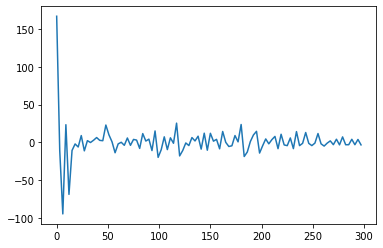

In [372]:
df.loc[df.layer == 0].grad_pct_old.plot()

(-1.8558001799317325, 2.1441998200682675)

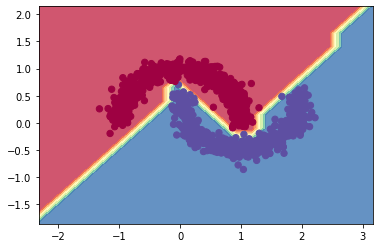

In [406]:

# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = batched_predict(W,B,Xmesh)
Z = np.array([s > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Second Order Updates

In [410]:
from jax import jacfwd, jacrev

def hessian(f):
    return jacfwd(jacrev(f))


In [407]:
W,B = init_network_params(layer_sizes, random.PRNGKey(1),1)

In [408]:
DW,DB = grad(loss,(0, 1))(W,B, X, y)

In [409]:
fw = lambda W: loss(W, B, X,y)
fb = lambda B: loss(W, B, X,y)

In [411]:
grads_w_2 = hessian(fw)(W)

In [413]:
grads_b_2 = hessian(fb)(B)

In [422]:
print(W[0][:2])
print('**********')
print(DW[0][:2])
print('**********')
print(grads_w_2[1][1].shape)

[[-0.50297046 -0.7609954 ]
 [-0.43815303  0.09172845]]
**********
[[-0.02080169  0.00543045]
 [ 0.09921139 -0.19139594]]
**********
(16, 16, 16, 16)


In [420]:
len(grads_w_2),len(grads_w_2[0]),W[0].shape

(3, 3, (16, 2))

In [ ]:
DW,DB = grad(loss,(0, 1))(W,b, x, y)
updated_W = []
updated_b = []
grads_params = []
for w, _b, _dw, _db in zip(W,b, DW,DB):
  new_w = w - _dw*lr
  new_b = _b - _db*lr

  updated_W.append(new_w)
  updated_b.append(new_b)
return updated_W,updated_b,DW,DB

# Hessian Scratch


In [426]:
def f(a,b): return (a**2)*(b**2)
p = lambda x: f(2,x)

In [427]:
grad(grad(p))(3.)

DeviceArray(8., dtype=float32)